# IBM Data Science Professional Certificate Capstone Project

## Looking for clusters of Chicago restaurants by Zip Code, population and income

# Introduction/ Business Problem

With the advent of the Covid-19 pandemic, restaurants face increasing challenges with business closures, employee lay-offs and, upon re-opening, maintaining profitability while conforming to public health, social distancing requirements. To mitigate the loss of revenue, some establishments are trying to promote out-of-home sales, enabled by online delivery companies such as GrubHub, Uber Eats, etc. The challenge for restaurants however is maintaining profitability when the online delivery companies can charge up to 30% commission on each order. See [LA Times article](https://www.latimes.com/food/story/2020-05-16/food-delivery-app-commissions-ubereats-grubhub-doordash) and [Forbes article](https://www.forbes.com/sites/forbesfinancecouncil/2020/05/04/why-food-delivery-companies-may-be-doing-more-harm-than-good-and-how-restaurants-can-fix-it/#392d841a1b3b).

There are many factors that are critical to a retaurant's success, such as proximity to customers, competition, labor costs, commercial rents, street location, etc.  One hypothesis for successful restaurants in a post-Covid-19 world is that they will need to find more customers with more income and locate closer to them to enable more direct order pickup without reliance on 3rd party delivery companies.

This analysis will examine whether restaurant cluster data from Fousquare, combined with income and population data by zip code can define new opportunities for opening restaurants by existing restaurateurs and new restaurant investors.


## Data

This analysis will use the Foursquare Places API as well as publicly available data to rank Chicago zip codes by population density, average income, and the number of competing restaurants. The following data sets will be used:
1.	[US Zip Codes with Latitude and Longitude](https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/)  This national data set supplies zip codes with geospatial coordinates. Latitude and Longitude from Chicago zip codes, beginning with "606", will be extracted to form the foundation of later API calls, using FourSquare.
2.	[Population by US Zip Code](https://www.kaggle.com/census/us-population-by-zip-code?select=population_by_zip_2010.csv) This is a Kaggle data set that shows population by zip code, as of 2010.
3.	[Income by US Zip Code](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi) This is a large data set from the IRS, from which median income by zip code can be extracted.
4.	[The FourSquare Places API](https://developer.foursquare.com/places) Foursquare data will be used to specify the number of restaurant venues by zip code.


## Methodology

The approach will be to develop stratified maps showing Chicago zip codes, separated into tiers, based on population density and median income. Foursquare venue data will then be overlaid to show clustering of venues by zip code. This analysis will then aim to enhance any clustering by examining primarily food venues while excluding businesses such as facial salons and yoga studios. Lastly the analyis will incorporate income and population by zip code to test whether more well defined clusters emerge.

### Population Data

Population data was drawn from a Kaggle data set for the zip codes that begin with "606", representing the city of Chicago.  A .csv file was uploaded into a SQL database, from which queries could be performed.  Once the relevant data was converted into a dataframe, histogram and choropleth maps were developed, using MatPlotLib and Folium respectively.

### Income Data

Income data was drawn from IRS data set for the zip codes that begin with "606", representing the city of Chicago.  A .csv file was uploaded into a SQL database, from which queries could be performed.  Total individual income for each zip code was divided by the total number of individual tax returns to derive an "Average Income" for each zip code. Once the relevant data was converted into a dataframe, histogram and choropleth maps were developed, using MatPlotLib and Folium respectively.

### Chicago Zip Code Coordinate Data

Chicago Zip Code Coordinate data was drawn from public data from opendatasoft.com.  A geojson file was uploaded to the [Github repository](https://github.com/JimDingo/Coursera_Capstone) for this project, from which choropleth maps could be developed.  

### Foursquare Data

Venue data for Chicago zip codes was drawn from Foursquare Places API for the zip codes that begin with "606", representing the city of Chicago.  A json file was downloaded and converted to a dataframe.  The first level of clustering downloaded all venues for a given zip code, including restaurants, yoga studios, nail salons, etc.  A second level of clustering was performed that eliminated the non-food establishments to be more relevant to the restaurant industry.  A third level of clustering added income and population by zip code to the food concentrated list of venues.  Due the large range of both population and income by zip code, income and population were normalized, using MinMax scaling from the SKLearn python library.  

# Installing Libraries

In [1]:
!pip install ipython-sql
%load_ext sql

In [2]:
import ibm_db
import ibm_db_sa
import ibm_db_dbi
import pandas as pd

In [3]:
!pip install PyMySQL

In [4]:
import pymysql as pym

In [5]:
%sql ibm_db_sa://csh14303:mnp5+d3ms73w9jjk@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB

## Prepare zip code-population data

In [6]:
%sql select * from CHI_POP_BY_ZIP limit 15

 * ibm_db_sa://csh14303:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


[(1301, 60644),
 (1, 60604),
 (963, 60618),
 (782, 60653),
 (280, 60642),
 (535, 60614),
 (368, 60611),
 (387, 60614),
 (685, 60654),
 (1363, 60644),
 (985, 60647),
 (518, 60609),
 (42, 60654),
 (1016, 60618),
 (2043, 60649)]

### Group data by zip code and create dataframe

In [7]:
conn='ibm_db_sa://csh14303:mnp5+d3ms73w9jjk@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB'

In [8]:
df_CHI_POP=pd.read_sql_query('select SUM("population"), "zipcode" from CHI_POP_BY_ZIP group by "zipcode"', conn)

In [9]:
df_CHI_POP.head(10)

1  zipcode
0   33330    60601
1    3612    60602
2    1479    60603
3    1710    60604
4   74004    60605
5    6924    60606
6   71691    60607
7  248217    60608
8  194718    60609
9  113178    60610

Correct Column names

In [10]:
df_CHI_POP=df_CHI_POP.rename(columns = {'1':'population'})

## Prepare zip code-income data

In [11]:
%sql select * from INCOME_BY_ZIP LIMIT10

 * ibm_db_sa://csh14303:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


[(60601, None, 8050, 2604217),
 (60602, None, 1180, 359412),
 (60603, None, 1270, 636344),
 (60604, None, 600, 303516),
 (60605, None, 14520, 1942386),
 (60606, None, 2610, 1109602),
 (60607, None, 13160, 1911711),
 (60608, None, 30520, 1332951),
 (60609, None, 24400, 922766),
 (60610, None, 23420, 3976426),
 (60611, None, 19990, 7317313),
 (60612, None, 14560, 761172),
 (60613, None, 28880, 2969785),
 (60614, None, 35300, 8135422),
 (60615, None, 18690, 1273169),
 (60616, None, 24640, 1559472),
 (60617, None, 34070, 1322801),
 (60618, None, 44340, 3553898),
 (60619, None, 28200, 1047126),
 (60620, None, 30300, 1012612),
 (60621, None, 10460, 254712),
 (60622, None, 28800, 3067322),
 (60623, None, 31770, 919455),
 (60624, None, 14180, 381666),
 (60625, None, 36310, 2318071),
 (60626, None, 23260, 1094393),
 (60628, None, 28830, 995864),
 (60629, None, 48140, 1704748),
 (60630, None, 27320, 1607202),
 (60631, None, 15360, 1346797),
 (60632, None, 36770, 1244131),
 (60633, None, 5710, 259793),
 (60634, None, 38310, 1890464),
 (60636, None, 13530, 342371),
 (60637, None, 18290, 1025708),
 (60638, None, 27710, 1534329),
 (60639, None, 38520, 1284515),
 (60640, None, 34840, 2564346),
 (60641, None, 34200, 1702825),
 (60642, None, 11680, 1183245),
 (60643, None, 24180, 1540103),
 (60644, None, 18490, 522395),
 (60645, None, 20820, 1204524),
 (60646, None, 13580, 1358541),
 (60647, None, 44380, 3355062),
 (60649, None, 18810, 684214),
 (60651, None, 27070, 840601),
 (60652, None, 20190, 958491),
 (60653, None, 13430, 626287),
 (60654, None, 13260, 2833227),
 (60655, None, 14100, 1168370),
 (60656, None, 14710, 909645),
 (60657, None, 40150, 5144046),
 (60659, None, 17900, 879571),
 (60660, None, 21730, 1324135),
 (60661, None, 6860, 1081200),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, None),
 (None, None, None, 

In [12]:
df_CHI_INC=pd.read_sql_query('select * from INCOME_BY_ZIP', conn)

In [13]:
df_CHI_INC = df_CHI_INC.drop(['agi_levels'], axis=1)

In [14]:
df_CHI_INC.dropna(subset = ["zip_code"], inplace=True)

In [15]:
df_CHI_INC.shape

(56, 3)

In [16]:
df_CHI_INC.head()

zip_code  no_of_returns        agi
0   60601.0         8050.0  2604217.0
1   60602.0         1180.0   359412.0
2   60603.0         1270.0   636344.0
3   60604.0          600.0   303516.0
4   60605.0        14520.0  1942386.0

In [17]:
df_CHI_INC.dtypes

zip_code         float64
no_of_returns    float64
agi              float64
dtype: object

In [18]:
df_CHI_INC=df_CHI_INC.rename(columns = {'zip_code':'zipcode'})

Calculate average income for each zip code

In [19]:
df_CHI_INC['avg_income'] = (df_CHI_INC['agi']*1000)/df_CHI_INC['no_of_returns']

In [20]:
df_CHI_INC = df_CHI_INC.astype(int)

In [21]:
df_CHI_INC.head(10)

zipcode  no_of_returns      agi  avg_income
0    60601           8050  2604217      323505
1    60602           1180   359412      304586
2    60603           1270   636344      501058
3    60604            600   303516      505860
4    60605          14520  1942386      133773
5    60606           2610  1109602      425134
6    60607          13160  1911711      145266
7    60608          30520  1332951       43674
8    60609          24400   922766       37818
9    60610          23420  3976426      169787

## Exploratory Analysis and Visualization of Income and Population Data

In [22]:
df_CHI_INC.drop(['no_of_returns', 'agi'], axis=1, inplace=True)

In [23]:
df_CHI_INC.set_index('zipcode', inplace=True)
df_CHI_INC.head()

avg_income
zipcode            
60601        323505
60602        304586
60603        501058
60604        505860
60605        133773

In [24]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


In [25]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(df_CHI_INC,bins=20)

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[20 14  5  4  2  2  1  1  1  0  0  1  1  0  1  0  1  0  0  2]
[ 24351.    48426.45  72501.9   96577.35 120652.8  144728.25 168803.7
 192879.15 216954.6  241030.05 265105.5  289180.95 313256.4  337331.85
 361407.3  385482.75 409558.2  433633.65 457709.1  481784.55 505860.  ]


### Great disparity between low income zip codes and two zip codes with extremely high average income.

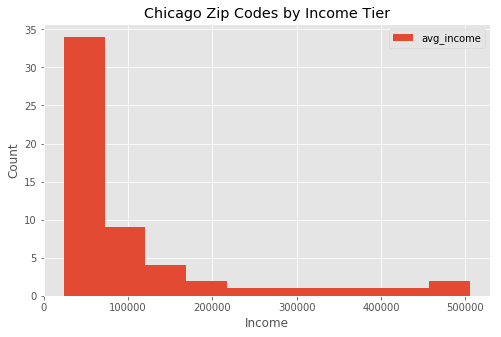

In [26]:
df_CHI_INC.plot(kind='hist', figsize=(8, 5))

plt.title('Chicago Zip Codes by Income Tier') # add a title to the histogram
plt.ylabel('Count') # add y-label
plt.xlabel('Income') # add x-label

plt.show()

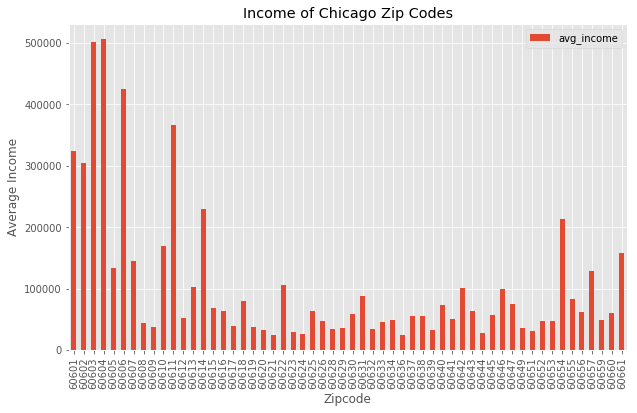

In [27]:
df_CHI_INC.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Zipcode') # add to x-label to the plot
plt.ylabel('Average Income') # add y-label to the plot
plt.title('Income of Chicago Zip Codes') # add title to the plot

plt.show()

In [28]:
df_CHI_POP.set_index('zipcode', inplace=True)
df_CHI_POP.head()

population
zipcode            
60601         33330
60602          3612
60603          1479
60604          1710
60605         74004

In [29]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(df_CHI_POP,bins=20)

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[4 2 2 1 7 2 4 5 7 3 0 6 3 2 2 2 3 0 0 1]
[  1479.    18492.45  35505.9   52519.35  69532.8   86546.25 103559.7
 120573.15 137586.6  154600.05 171613.5  188626.95 205640.4  222653.85
 239667.3  256680.75 273694.2  290707.65 307721.1  324734.55 341748.  ]


### Population by zip code approximates a normal distribution

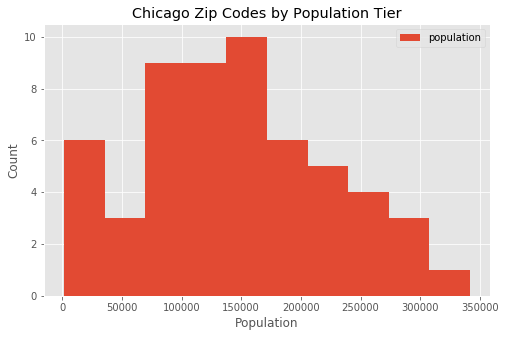

In [30]:
df_CHI_POP.plot(kind='hist', figsize=(8, 5))

plt.title('Chicago Zip Codes by Population Tier') # add a title to the histogram
plt.ylabel('Count') # add y-label
plt.xlabel('Population') # add x-label

plt.show()

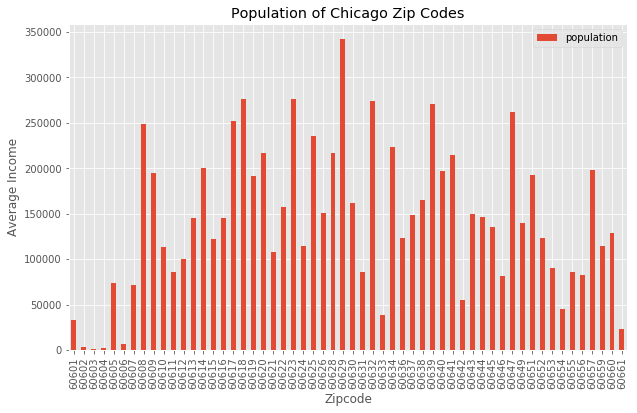

In [31]:
df_CHI_POP.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Zipcode') # add to x-label to the plot
plt.ylabel('Average Income') # add y-label to the plot
plt.title('Population of Chicago Zip Codes') # add title to the plot

plt.show()

In [32]:
df_MERGE_PI = pd.merge(df_CHI_INC, df_CHI_POP, on='zipcode')


In [33]:
df_MERGE_PI.head()

avg_income  population
zipcode                        
60601        323505       33330
60602        304586        3612
60603        501058        1479
60604        505860        1710
60605        133773       74004

### Plot of Population and Income show two zip codes with extremely high income but sparse local population and many well populated, low income zip codes.

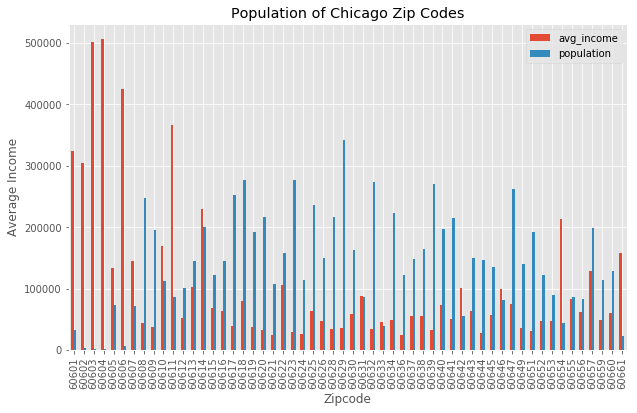

In [34]:
df_MERGE_PI.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Zipcode') # add to x-label to the plot
plt.ylabel('Average Income') # add y-label to the plot
plt.title('Population of Chicago Zip Codes') # add title to the plot

plt.show()

Chloropleth visualization

In [35]:
!pip install folium

In [36]:
import folium
print('Folium installed and imported!')

Folium installed and imported!


In [37]:
latitude = 41.8781
longitude = -87.6298

In [38]:
df_CHI_POP = df_CHI_POP.reset_index()

In [39]:
df_CHI_POP=df_CHI_POP.rename(columns = {'zip_code':'zip'})

In [40]:
df_CHI_POP.head()

zipcode  population
0    60601       33330
1    60602        3612
2    60603        1479
3    60604        1710
4    60605       74004

In [41]:
df_CHI_POP=df_CHI_POP.rename(columns = {'zipcode':'zip'})

In [42]:
import json

In [43]:
!wget --quiet https://raw.githubusercontent.com/JimDingo/Coursera_Capstone/master/Boundaries-ZIPCodes2.geojson -O Boundaries-ZIPCodes2.geojson
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [44]:
Chi_geo = r'Boundaries-ZIPCodes2.geojson' # geojson file

In [45]:
df_CHI_POP.head()

zip  population
0  60601       33330
1  60602        3612
2  60603        1479
3  60604        1710
4  60605       74004

In [46]:
ChicagoPOP_map = folium.Map(location=[latitude, longitude], zoom_start=11)

ChicagoPOP_map

## Choropleth map shows population is dispersed away from the Chicago downtown which is slightly populated

In [47]:
ChicagoPOP_map.choropleth(
    geo_data=Chi_geo,
    name='choropleth',
    data=df_CHI_POP,
    columns=['zip','population'],
    key_on='feature.properties.zip',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.6,
    legend_name='Population'
)

# display map
ChicagoPOP_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [48]:
df_CHI_INC = df_CHI_INC.reset_index()

In [49]:
df_CHI_INC.head()

zipcode  avg_income
0    60601      323505
1    60602      304586
2    60603      501058
3    60604      505860
4    60605      133773

In [50]:
df_CHI_INC=df_CHI_INC.rename(columns = {'zipcode':'zip'})

In [51]:
ChicagoINC_map = folium.Map(location=[latitude, longitude], zoom_start=11)

ChicagoINC_map

## ## Choropleth map shows income is concentrated in the Chicago downtown area

In [52]:
ChicagoINC_map.choropleth(
    geo_data=Chi_geo,
    name='choropleth',
    data=df_CHI_INC,
    columns=['zip','avg_income'],
    key_on='feature.properties.zip',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.6,
    legend_name='Population Density by Chicago Zip Code'
)

# display map
ChicagoINC_map

In [53]:
df_CHI_INC=df_CHI_INC.rename(columns = {'zip':'Zip Code'})

In [54]:
df_CHI_ZIP=pd.read_sql_query('select * from CHI_ZIP_COOR', conn)

#### Combining Zip Code Coordinates with Population and Income data in a dataframe.

In [55]:
df_CHI_ZIP.head(3)

Zip   Latitude  Longitude
0  60601  41.886456  -87.62325
1  60602  41.882937  -87.62874
2  60603  41.880446  -87.63014

In [56]:
df_CHI_ZIP = df_CHI_ZIP.rename(columns = {'Zip':'zipcode'})

In [57]:
df_CHI_ZIP

zipcode   Latitude  Longitude
0     60601  41.886456 -87.623250
1     60602  41.882937 -87.628740
2     60603  41.880446 -87.630140
3     60604  41.877589 -87.628180
4     60605  41.860019 -87.618700
5     60606  41.882582 -87.637600
6     60607  41.875882 -87.651140
7     60608  41.850532 -87.669900
8     60609  41.814283 -87.652820
9     60610  41.898582 -87.637100
10    60611  41.904667 -87.625040
11    60612  41.880682 -87.687700
12    60613  41.953256 -87.662900
13    60614  41.922682 -87.654320
14    60615  41.801525 -87.602150
15    60616  41.847400 -87.631260
16    60617  41.719973 -87.555700
17    60618  41.945681 -87.704800
18    60619  41.744834 -87.604440
19    60620  41.740483 -87.652820
20    60621  41.776983 -87.640400
21    60622  41.900332 -87.669270
22    60623  41.850232 -87.718000
23    60624  41.879365 -87.721990
24    60625  41.971614 -87.702560
25    60626  42.009731 -87.669380
26    60628  41.695434 -87.622550
27    60629  41.777482 -87.711550
28    60630  41.971044 -87.758690
29    60631  41.996230 -87.810910
30    60632  41.809299 -87.710500
31    60633  41.655423 -87.553650
32    60634  41.944454 -87.796540
33    60636  41.776633 -87.668540
34    60637  41.779384 -87.605440
35    60638  41.787982 -87.773800
36    60639  41.921431 -87.754150
37    60640  41.973181 -87.666500
38    60641  41.946431 -87.745760
39    60643  41.696433 -87.659930
40    60644  41.881331 -87.756710
41    60645  42.008956 -87.696340
42    60646  41.995331 -87.760100
43    60647  41.921126 -87.700850
44    60648  41.335445 -87.785286
45    60649  41.761734 -87.570720
46    60650  41.818682 -87.743454
47    60651  41.901485 -87.740550
48    60652  41.744600 -87.711880
49    60653  41.819833 -87.612690
50    60654  41.888627 -87.635380
51    60655  41.696283 -87.699120
52    60656  41.975080 -87.816300
53    60657  41.940832 -87.658520
54    60659  41.991381 -87.703780
55    60660  41.990631 -87.666700
56    60661  41.882082 -87.644610

In [58]:
df_CHI_ZIP=df_CHI_ZIP.rename(columns = {'zipcode':'Zip Code'})

In [59]:
df_MERGE_PI = df_MERGE_PI.reset_index()

In [60]:
df_MERGE_PI=df_MERGE_PI.rename(columns = {'zipcode':'Zip Code'})

In [61]:
df_MERGE_PIZC = pd.merge(df_MERGE_PI, df_CHI_ZIP, on='Zip Code')

In [62]:
df_MERGE_PIZC.head(3)

Zip Code  avg_income  population   Latitude  Longitude
0     60601      323505       33330  41.886456  -87.62325
1     60602      304586        3612  41.882937  -87.62874
2     60603      501058        1479  41.880446  -87.63014

#### Importing libraries for images and json files

In [63]:
import requests # library to handle requests
import numpy as np # library to handle data in a vectorized manner

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

print('Libraries imported.')

Libraries imported.


#### Preparing to employ Foursquare API calls

In [64]:
CLIENT_ID = 'B0DS25U1DJ0XKSWPYO3KBXGAVHYIIDKOU11VQTHLW5SODOVH' # your Foursquare ID
CLIENT_SECRET = 'TS2RZJURENOTLGQVST4ICDLTXPHOOJA3X0KVJNX344WBJ1LB' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B0DS25U1DJ0XKSWPYO3KBXGAVHYIIDKOU11VQTHLW5SODOVH
CLIENT_SECRET:TS2RZJURENOTLGQVST4ICDLTXPHOOJA3X0KVJNX344WBJ1LB


In [65]:
print(latitude, longitude)

41.8781 -87.6298


In [66]:
search_query = 'Restaurant'
radius = 5000
print(search_query + ' .... OK!')

Restaurant .... OK!


In [67]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=B0DS25U1DJ0XKSWPYO3KBXGAVHYIIDKOU11VQTHLW5SODOVH&client_secret=TS2RZJURENOTLGQVST4ICDLTXPHOOJA3X0KVJNX344WBJ1LB&ll=41.8781,-87.6298&v=20180604&query=Restaurant&radius=5000&limit=100'

In [68]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef241dc3907e700235c4058'},
 'response': {'venues': [{'id': '4b2bedd4f964a520e6bd24e3',
    'name': 'The Berghoff Restaurant',
    'location': {'address': '17 W Adams St',
     'crossStreet': 'btwn S Dearborn St & S State St',
     'lat': 41.879334126547164,
     'lng': -87.62836809709047,
     'labeledLatLngs': [{'label': 'display',
       'lat': 41.879334126547164,
       'lng': -87.62836809709047}],
     'distance': 181,
     'postalCode': '60603',
     'cc': 'US',
     'city': 'Chicago',
     'state': 'IL',
     'country': 'United States',
     'formattedAddress': ['17 W Adams St (btwn S Dearborn St & S State St)',
      'Chicago, IL 60603',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d10d941735',
      'name': 'German Restaurant',
      'pluralName': 'German Restaurants',
      'shortName': 'German',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/german_',
       'suffix': '.png'},
      'primary': T

In [69]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

categories delivery.id  \
0  [{'id': '4bf58dd8d48988d10d941735', 'name': 'G...         NaN   
1  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...         NaN   
2  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...      541230   
3  [{'id': '4bf58dd8d48988d145941735', 'name': 'C...         NaN   
4  [{'id': '4bf58dd8d48988d110941735', 'name': 'I...         NaN   

               delivery.provider.icon.name  \
0                                      NaN   
1                                      NaN   
2  /delivery_provider_grubhub_20180129.png   
3                                      NaN   
4                                      NaN   

              delivery.provider.icon.prefix delivery.provider.icon.sizes  \
0                                       NaN                          NaN   
1                                       NaN                          NaN   
2  https://fastly.4sqi.net/img/general/cap/                     [40, 50]   
3                                       NaN                          NaN   
4                                       NaN                          NaN   

  delivery.provider.name                                       delivery.url  \
0                    NaN                                                NaN   
1                    NaN                                                NaN   
2                grubhub  https://www.grubhub.com/restaurant/exchequer-r...   
3                    NaN                                                NaN   
4                    NaN                                                NaN   

   hasPerk                        id   location.address  ...  \
0    False  4b2bedd4f964a520e6bd24e3      17 W Adams St  ...   
1    False  4b9ad8c5f964a520ccdb35e3  327 S Plymouth Ct  ...   
2    False  40b28c80f964a52037fb1ee3   226 S Wabash Ave  ...   
3    False  4b295853f964a520489d24e3   201 W Madison St  ...   
4    False  51d896fc498ea6557a53478f  616 S Dearborn St  ...   

                           location.formattedAddress  \
0  [17 W Adams St (btwn S Dearborn St & S State S...   
1  [327 S Plymouth Ct (btwn W Jackson Blvd & W Va...   
2  [226 S Wabash Ave, Chicago, IL 60604, United S...   
3  [201 W Madison St (btwn Wells & Franklin St), ...   
4  [616 S Dearborn St, Chicago, IL 60605, United ...   

                             location.labeledLatLngs location.lat  \
0  [{'label': 'display', 'lat': 41.87933412654716...    41.879334   
1  [{'label': 'display', 'lat': 41.87713751627466...    41.877138   
2  [{'label': 'display', 'lat': 41.87881928744278...    41.878819   
3  [{'label': 'display', 'lat': 41.88190920166713...    41.881909   
4  [{'label': 'display', 'lat': 41.87387961462097...    41.873880   

  location.lng  location.neighborhood location.postalCode location.state  \
0   -87.628368                    NaN               60603             IL   
1   -87.627969                    NaN               60604             IL   
2   -87.625986                    NaN               60604             IL   
3   -87.634165                    NaN               60606             IL   
4   -87.629105                    NaN               60605             IL   

                         name    referralId venuePage.id  
0     The Berghoff Restaurant  v-1592934967     90487382  
1   Plymouth Restaurant & Bar  v-1592934967          NaN  
2  Exchequer Restaurant & Pub  v-1592934967          NaN  
3       65 Chinese Restaurant  v-1592934967          NaN  
4             Sofi Restaurant  v-1592934967          NaN  

[5 rows x 25 columns]

In [70]:
dataframe.shape

(50, 25)

In [71]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

name  \
0                             The Berghoff Restaurant   
1                           Plymouth Restaurant & Bar   
2                          Exchequer Restaurant & Pub   
3                               65 Chinese Restaurant   
4                                     Sofi Restaurant   
5                         Lockwood Restaurant and Bar   
6                              Opus Restaurant & Café   
7            Radisson Blu - Filini Restaurant and Bar   
8                       Sixty-Five Chinese Restaurant   
9               Chicago Curry House Indian Restaurant   
10                      Sixty-five Chinese Restaurant   
11                            Athena Greek Restaurant   
12                           Seven Bar and Restaurant   
13           Nepal House - Indian & Nepali Restaurant   
14                                Dao Thai Restaurant   
15                            Great Street Restaurant   
16                       Chicago Firehouse Restaurant   
17                                Wishbone Restaurant   
18                                 Bandera Restaurant   
19                             India House Restaurant   
20                         Cocoro Japanese Restaurant   
21                             Jetro/Restaurant Depot   
22                           Indian Garden Restaurant   
23                                  Orso's Restaurant   
24                                      RL Restaurant   
25                              65 Chinese Restaurant   
26                      Restaurant Opportunity Center   
27                                     S&S Restaurant   
28                  Mart Anthony's Italian Restaurant   
29                             Brokers Inn Restaurant   
30                             Amarit Thai Restaurant   
31                                 Phoenix Restaurant   
32              Rawabi Grill Mediterranean Restaurant   
33                                 Jimmy's Restaurant   
34          National Restaurant Association Solutions   
35                            Triple Crown Restaurant   
36                    Illinois Restaurant Association   
37                         HALO' Restaurant - Chicago   
38                    National Restaurant Association   
39                     Franconello Italian Restaurant   
40                               Bismilahi Restaurant   
41                             Markethouse Restaurant   
42                        Millennium Restaurant & Bar   
43  Allium Restaurant and Bar at Four Seasons Hote...   
44                                Illinois Restaurant   
45                               Himalayan Restaurant   
46                                   G & G Restaurant   
47                               Salerno's Restaurant   
48                       Oak Tree Restaurant & Bakery   
49                                  Rivers Restaurant   

                         categories                  address  cc     city  \
0                 German Restaurant            17 W Adams St  US  Chicago   
1                               Bar        327 S Plymouth Ct  US  Chicago   
2                               Pub         226 S Wabash Ave  US  Chicago   
3                Chinese Restaurant         201 W Madison St  US  Chicago   
4                Italian Restaurant        616 S Dearborn St  US  Chicago   
5           New American Restaurant           17 E Monroe St  US  Chicago   
6                              Café            65 E Adams St  US  Chicago   
7                Italian Restaurant        221 N Columbus Dr  US  Chicago   
8                Chinese Restaurant         201 W Madison St  US  Chicago   
9                 Indian Restaurant        899 S Plymouth Ct  US  Chicago   
10               Chinese Restaurant           225 S Canal St  US  Chicago   
11                 Greek Restaurant         212 S Halsted St  US  Chicago   
12                              Bar        400 E Randolph St  US  Chicago   
13                Indian Restaurant      1301 S Michigan Ave  U

In [72]:
dataframe_filtered.shape

(50, 16)

In [73]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    CHI_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
    CHI_venues.columns = ['zip', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(CHI_venues)

#### Getting Foursquare venue data for each zip code.

In [74]:
chicago_venues = getNearbyVenues(names=df_MERGE_PIZC['Zip Code'],
                                   latitudes=df_MERGE_PIZC['Latitude'],
                                   longitudes=df_MERGE_PIZC['Longitude']
                                  )

60601
60602
60603
60604
60605
60606
60607
60608
60609
60610
60611
60612
60613
60614
60615
60616
60617
60618
60619
60620
60621
60622
60623
60624
60625
60626
60628
60629
60630
60631
60632
60633
60634
60636
60637
60638
60639
60640
60641
60643
60644
60645
60646
60647
60649
60651
60652
60653
60654
60655
60656
60657
60659
60660
60661


In [75]:
print(chicago_venues.shape)

(1561, 7)


In [76]:
chicago_venues.head()

zip  Neighborhood Latitude  Neighborhood Longitude  \
0  60601              41.886456               -87.62325   
1  60601              41.886456               -87.62325   
2  60601              41.886456               -87.62325   
3  60601              41.886456               -87.62325   
4  60601              41.886456               -87.62325   

                         Venue  Venue Latitude  Venue Longitude  \
0  Chicago Architecture Center       41.887720       -87.623650   
1    Roti Modern Mediterranean       41.886048       -87.624948   
2                   sweetgreen       41.884964       -87.624728   
3             St. Jane Chicago       41.886573       -87.624902   
4        Virgin Hotels Chicago       41.886065       -87.625853   

             Venue Category  
0             Tour Provider  
1  Mediterranean Restaurant  
2               Salad Place  
3                     Hotel  
4                     Hotel

In [77]:
chicago_venues.shape

(1561, 7)

In [78]:
print('There are {} unique categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 251 unique categories.


Using the "Get Dummies" method to expand venue categories.

In [79]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['zip'] = chicago_venues['zip'] 

# move zip column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

zip  ATM  Adult Boutique  American Restaurant  Amphitheater  \
0  60601    0               0                    0             0   
1  60601    0               0                    0             0   
2  60601    0               0                    0             0   
3  60601    0               0                    0             0   
4  60601    0               0                    0             0   

   Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  \
0               0             0       0                 0   
1               0             0       0                 0   
2               0             0       0                 0   
3               0             0       0                 0   
4               0             0       0                 0   

   Argentinian Restaurant  ...  Video Store  Vietnamese Restaurant  \
0                       0  ...            0                      0   
1                       0  ...            0                      0   
2                       0  ...            0                      0   
3                       0  ...            0                      0   
4                       0  ...            0                      0   

   Waterfront  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
0           0           0         0          0       0            0   
1           0           0         0          0       0            0   
2           0           0         0          0       0            0   
3           0           0         0          0       0            0   
4           0           0         0          0       0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 252 columns]

In [80]:
chicago_onehot.shape

(1561, 252)

In [81]:
chicago_grouped = chicago_onehot.groupby('zip').mean().reset_index()
chicago_grouped

zip       ATM  Adult Boutique  American Restaurant  Amphitheater  \
0   60601  0.000000        0.000000             0.010000          0.01   
1   60602  0.000000        0.000000             0.020000          0.00   
2   60603  0.000000        0.000000             0.020000          0.00   
3   60604  0.000000        0.000000             0.030000          0.00   
4   60605  0.000000        0.000000             0.000000          0.00   
5   60606  0.000000        0.000000             0.040000          0.00   
6   60607  0.000000        0.000000             0.000000          0.00   
7   60608  0.000000        0.000000             0.000000          0.00   
8   60610  0.000000        0.000000             0.030303          0.00   
9   60611  0.000000        0.000000             0.050000          0.00   
10  60612  0.000000        0.000000             0.000000          0.00   
11  60613  0.000000        0.000000             0.031250          0.00   
12  60614  0.000000        0.000000             0.050000          0.00   
13  60615  0.000000        0.000000             0.000000          0.00   
14  60616  0.000000        0.000000             0.000000          0.00   
15  60617  0.000000        0.000000             0.000000          0.00   
16  60618  0.000000        0.000000             0.000000          0.00   
17  60619  0.000000        0.000000             0.000000          0.00   
18  60620  0.000000        0.000000             0.000000          0.00   
19  60621  0.000000        0.000000             0.000000          0.00   
20  60622  0.000000        0.000000             0.000000          0.00   
21  60623  0.000000        0.000000             0.000000          0.00   
22  60624  0.000000        0.000000             0.000000          0.00   
23  60625  0.000000        0.000000             0.000000          0.00   
24  60626  0.000000        0.000000             0.073171          0.00   
25  60628  0.000000        0.000000             0.000000          0.00   
26  60629  0.000000        0.000000             0.000000          0.00   
27  60630  0.000000        0.000000             0.040000          0.00   
28  60631  0.000000        0.000000             0.000000          0.00   
29  60632  0.000000        0.000000             0.000000          0.00   
30  60633  0.000000        0.000000             0.000000          0.00   
31  60634  0.000000        0.000000             0.000000          0.00   
32  60636  0.000000        0.000000             0.000000          0.00   
33  60637  0.000000        0.000000             0.000000          0.00   
34  60638  0.000000        0.000000             0.000000          0.00   
35  60639  0.000000        0.000000             0.000000          0.00   
36  60640  0.000000        0.022727             0.022727          0.00   
37  60641  0.000000        0.000000             0.000000          0.00   
38  60643  0.000000        0.000000             0.200000          0.00   
39  60644  0.142857        0.000000             0.000000          0.00   
40  60645  0.000000        0.000000             0.071429          0.00   
41  60646  0.000000        0.000000             0.055556          0.00   
42  60647  0.000000        0.000000             0.000000          0.00   
43  60649  0.000000        0.000000             0.000000          0.00   
44  60651  0.000000        0.000000             0.000000          0.00   
45  60652  0.000000        0.000000             0.000000          0.00   
46  60653  0.000000        0.000000             0.142857          0.00   
47  60654  0.000000        0.000000             0.034483          0.00   
48  60655  0.000000        0.000000             0.000000          0.00   
49  60656  0.000000        0.000000             0.000000          0.00   
50  60657  0.000000        0.000000             0.000000          0.00   
51  60659  0.000000        0.000000             0.000000          0.00   
52  60660  0.000000        0.000000             0.000000          0.00   
53  60661 

In [82]:
chicago_grouped.shape

(54, 252)

In [83]:
chicago_grouped['Zip Code']=chicago_grouped['zip']

In [84]:
chicago_grouped['Zip Code'] = chicago_grouped['Zip Code'].apply(str)

In [85]:
chicago_grouped.head(3)

zip  ATM  Adult Boutique  American Restaurant  Amphitheater  \
0  60601  0.0             0.0                 0.01          0.01   
1  60602  0.0             0.0                 0.02          0.00   
2  60603  0.0             0.0                 0.02          0.00   

   Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  \
0             0.0           0.0     0.0              0.00   
1             0.0           0.0     0.0              0.01   
2             0.0           0.0     0.0              0.01   

   Argentinian Restaurant  ...  Vietnamese Restaurant  Waterfront  Whisky Bar  \
0                     0.0  ...                    0.0        0.01         0.0   
1                     0.0  ...                    0.0        0.01         0.0   
2                     0.0  ...                    0.0        0.00         0.0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  \
0       0.0        0.0    0.01          0.0            0.0          0.0   
1       0.0        0.0    0.00          0.0            0.0          0.0   
2       0.0        0.0    0.00          0.0            0.0          0.0   

   Zip Code  
0     60601  
1     60602  
2     60603  

[3 rows x 253 columns]

In [86]:
cols = list(chicago_grouped.columns)
cols = [cols[-1]] + cols[:-1]
chicago_grouped = chicago_grouped[cols]

In [87]:
chicago_grouped.head(3)

Zip Code    zip  ATM  Adult Boutique  American Restaurant  Amphitheater  \
0    60601  60601  0.0             0.0                 0.01          0.01   
1    60602  60602  0.0             0.0                 0.02          0.00   
2    60603  60603  0.0             0.0                 0.02          0.00   

   Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  ...  Video Store  \
0             0.0           0.0     0.0              0.00  ...          0.0   
1             0.0           0.0     0.0              0.01  ...          0.0   
2             0.0           0.0     0.0              0.01  ...          0.0   

   Vietnamese Restaurant  Waterfront  Whisky Bar  Wine Bar  Wine Shop  Winery  \
0                    0.0        0.01         0.0       0.0        0.0    0.01   
1                    0.0        0.01         0.0       0.0        0.0    0.00   
2                    0.0        0.00         0.0       0.0        0.0    0.00   

   Wings Joint  Women's Store  Yoga Studio  
0          0.0            0.0          0.0  
1          0.0            0.0          0.0  
2          0.0            0.0          0.0  

[3 rows x 253 columns]

In [88]:
chicago_grouped.drop(['zip'], axis=1, inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Listing the top 5 venues by zip code

In [89]:
num_top_venues = 5

for hood in chicago_grouped['Zip Code']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Zip Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(str)
    temp = temp.round({'freq': 1})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----60601----
                venue  freq
0               Hotel  0.14
1         Coffee Shop  0.09
2  Seafood Restaurant  0.04
3          Steakhouse  0.03
4               Plaza  0.03


----60602----
         venue  freq
0        Hotel  0.07
1      Theater  0.06
2  Coffee Shop  0.05
3        Plaza  0.03
4       Bakery  0.03


----60603----
                venue  freq
0         Coffee Shop  0.08
1             Theater  0.05
2               Hotel  0.05
3  Mexican Restaurant  0.03
4      Sandwich Place  0.03


----60604----
                venue  freq
0         Coffee Shop  0.06
1      Sandwich Place  0.05
2  Italian Restaurant  0.04
3               Hotel  0.04
4         Pizza Place  0.03


----60605----
                venue                  freq
0    Football Stadium   0.14285714285714285
1                Park   0.09523809523809523
2       Historic Site   0.09523809523809523
3  English Restaurant  0.047619047619047616
4              Museum  0.047619047619047616


----60606----
            

In [90]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [91]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
chicago_venues_sorted = pd.DataFrame(columns=columns)
chicago_venues_sorted['Zip Code'] = chicago_grouped['Zip Code']

for ind in np.arange(chicago_grouped.shape[0]):
    chicago_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

chicago_venues_sorted.head()

Zip Code 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    60601                 Hotel           Coffee Shop    Seafood Restaurant   
1    60602                 Hotel               Theater           Coffee Shop   
2    60603           Coffee Shop               Theater                 Hotel   
3    60604           Coffee Shop        Sandwich Place                 Hotel   
4    60605      Football Stadium         Historic Site                  Park   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                Bakery            Steakhouse                 Plaza   
1                Bakery                 Plaza             Gastropub   
2    Mexican Restaurant        Sandwich Place      Asian Restaurant   
3    Italian Restaurant   American Restaurant               Theater   
4    Athletics & Sports   Sporting Goods Shop          Burger Joint   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Museum                  Park               Theater   
1        Sandwich Place                   Bar        Farmers Market   
2           Snack Place          Burger Joint           Salad Place   
3                 Plaza           Pizza Place          Cocktail Bar   
4                Bistro      Sushi Restaurant                Museum   

  10th Most Common Venue  
0            Pizza Place  
1            Snack Place  
2                  Plaza  
3             Smoke Shop  
4     English Restaurant

In [92]:
chicago_venues_sorted.shape

(54, 11)

#### Creating K means clusters from venue data

In [93]:
from sklearn.cluster import KMeans

In [94]:
# set number of clusters
kclusters = 5

chicago_grouped_clustering = chicago_grouped.drop('Zip Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

In [95]:
df_CHI_ZIP = df_CHI_ZIP.rename(columns = {'zipcode':'Zip Code'})

In [96]:
chicago_venues_sorted['Zip Code'] = chicago_venues_sorted['Zip Code'].astype(int)

In [97]:
# add clustering labels

chicago_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = df_CHI_ZIP

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chicago_merged = chicago_merged.join(chicago_venues_sorted.set_index('Zip Code'), on='Zip Code')

chicago_merged.head() # check the last columns!

Zip Code   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0     60601  41.886456  -87.62325             1.0                 Hotel   
1     60602  41.882937  -87.62874             1.0                 Hotel   
2     60603  41.880446  -87.63014             1.0           Coffee Shop   
3     60604  41.877589  -87.62818             1.0           Coffee Shop   
4     60605  41.860019  -87.61870             2.0      Football Stadium   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop    Seafood Restaurant                Bakery   
1               Theater           Coffee Shop                Bakery   
2               Theater                 Hotel    Mexican Restaurant   
3        Sandwich Place                 Hotel    Italian Restaurant   
4         Historic Site                  Park    Athletics & Sports   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0            Steakhouse                 Plaza                Museum   
1                 Plaza             Gastropub        Sandwich Place   
2        Sandwich Place      Asian Restaurant           Snack Place   
3   American Restaurant               Theater                 Plaza   
4   Sporting Goods Shop          Burger Joint                Bistro   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                  Park               Theater            Pizza Place  
1                   Bar        Farmers Market            Snack Place  
2          Burger Joint           Salad Place                  Plaza  
3           Pizza Place          Cocktail Bar             Smoke Shop  
4      Sushi Restaurant                Museum     English Restaurant

In [99]:
chicago_merged

Zip Code   Latitude  Longitude  Cluster Labels  \
0      60601  41.886456 -87.623250             1.0   
1      60602  41.882937 -87.628740             1.0   
2      60603  41.880446 -87.630140             1.0   
3      60604  41.877589 -87.628180             1.0   
4      60605  41.860019 -87.618700             2.0   
5      60606  41.882582 -87.637600             1.0   
6      60607  41.875882 -87.651140             1.0   
7      60608  41.850532 -87.669900             1.0   
8      60609  41.814283 -87.652820             NaN   
9      60610  41.898582 -87.637100             1.0   
10     60611  41.904667 -87.625040             1.0   
11     60612  41.880682 -87.687700             2.0   
12     60613  41.953256 -87.662900             1.0   
13     60614  41.922682 -87.654320             1.0   
14     60615  41.801525 -87.602150             1.0   
15     60616  41.847400 -87.631260             3.0   
16     60617  41.719973 -87.555700             2.0   
17     60618  41.945681 -87.704800             1.0   
18     60619  41.744834 -87.604440             3.0   
19     60620  41.740483 -87.652820             4.0   
20     60621  41.776983 -87.640400             3.0   
21     60622  41.900332 -87.669270             1.0   
22     60623  41.850232 -87.718000             2.0   
23     60624  41.879365 -87.721990             1.0   
24     60625  41.971614 -87.702560             2.0   
25     60626  42.009731 -87.669380             3.0   
26     60628  41.695434 -87.622550             1.0   
27     60629  41.777482 -87.711550             1.0   
28     60630  41.971044 -87.758690             1.0   
29     60631  41.996230 -87.810910             2.0   
30     60632  41.809299 -87.710500             1.0   
31     60633  41.655423 -87.553650             2.0   
32     60634  41.944454 -87.796540             2.0   
33     60636  41.776633 -87.668540             0.0   
34     60637  41.779384 -87.605440             2.0   
35     60638  41.787982 -87.773800             1.0   
36     60639  41.921431 -87.754150             3.0   
37     60640  41.973181 -87.666500             1.0   
38     60641  41.946431 -87.745760             1.0   
39     60643  41.696433 -87.659930             2.0   
40     60644  41.881331 -87.756710             1.0   
41     60645  42.008956 -87.696340             1.0   
42     60646  41.995331 -87.760100             1.0   
43     60647  41.921126 -87.700850             1.0   
44     60648  41.335445 -87.785286             NaN   
45     60649  41.761734 -87.570720             1.0   
46     60650  41.818682 -87.743454             NaN   
47     60651  41.901485 -87.740550             2.0   
48     60652  41.744600 -87.711880             0.0   
49     60653  41.819833 -87.612690             1.0   
50     60654  41.888627 -87.635380             1.0   
51     60655  41.696283 -87.699120             2.0   
52     60656  41.975080 -87.816300             2.0   
53     60657  41.940832 -87.658520             1.0   
54     60659  41.991381 -87.703780             1.0   
55     60660  41.990631 -87.666700             1.0   
56     60661  41.882082 -87.644610             1.0   

         1st Most Common Venue            2nd Most Common Venue  \
0                        Hotel                      Coffee Shop   
1                        Hotel                          Theater   
2                  Coffee Shop                          Theater   
3                  Coffee Shop                   Sandwich Place   
4             Football Stadium                    Historic Site   
5                  Coffee Shop                   Sandwich Place   
6             Greek Restaurant                      Coffee Shop   
7                Boat or Ferry                      Video Store   
8                          NaN                              NaN   
9         Gym / Fitness Center                              Bar   
10          Italian Restaurant                            Hotel   
11                 Gas Station                             Park   


In [100]:
chicago_merged = chicago_merged.dropna()

In [101]:
chicago_merged.shape

(54, 14)

In [102]:
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype(int)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Plotting K-Means clusters

In [103]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [104]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Zip Code'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [105]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
33     60636  Fast Food Restaurant         Train Station   
48     60652          Liquor Store            Sports Bar   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
33        Cosmetics Shop          Liquor Store        Discount Store   
48         Train Station           Yoga Studio   Empanada Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
33   Empanada Restaurant    English Restaurant         Event Service   
48    English Restaurant         Event Service               Exhibit   

   9th Most Common Venue 10th Most Common Venue  
33               Exhibit             Eye Doctor  
48            Eye Doctor     Falafel Restaurant

In [106]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code       1st Most Common Venue            2nd Most Common Venue  \
0      60601                       Hotel                      Coffee Shop   
1      60602                       Hotel                          Theater   
2      60603                 Coffee Shop                          Theater   
3      60604                 Coffee Shop                   Sandwich Place   
5      60606                 Coffee Shop                   Sandwich Place   
6      60607            Greek Restaurant                      Coffee Shop   
7      60608               Boat or Ferry                      Video Store   
9      60610        Gym / Fitness Center                              Bar   
10     60611          Italian Restaurant                            Hotel   
12     60613              Ice Cream Shop                      Bus Station   
13     60614                 Yoga Studio              Japanese Restaurant   
14     60615                 Bus Station                   Cosmetics Shop   
17     60618                 Bus Station                             Bank   
21     60622          Mexican Restaurant                              Bar   
23     60624                  Shoe Store             Fast Food Restaurant   
26     60628              Sandwich Place                       Steakhouse   
27     60629                Camera Store                      Pizza Place   
28     60630                         Bar                   Ice Cream Shop   
30     60632          Seafood Restaurant                        BBQ Joint   
35     60638                      Bakery                          Dog Run   
37     60640        Gym / Fitness Center                              Spa   
38     60641  Construction & Landscaping                      Art Gallery   
40     60644                         ATM  Southern / Soul Food Restaurant   
41     60645          Mexican Restaurant                Currency Exchange   
42     60646              Sandwich Place                            Plaza   
43     60647                Cocktail Bar               Mexican Restaurant   
45     60649          Seafood Restaurant                    Women's Store   
49     60653                 Coffee Shop                   Breakfast Spot   
50     60654                 Coffee Shop                              Bar   
53     60657                 Coffee Shop                   Sandwich Place   
54     60659          Mexican Restaurant                              Spa   
55     60660                 Pizza Place                          Theater   
56     60661     New American Restaurant                              Bar   

        3rd Most Common Venue 4th Most Common Venue  \
0          Seafood Restaurant                Bakery   
1                 Coffee Shop                Bakery   
2                       Hotel    Mexican Restaurant   
3                       Hotel    Italian Restaurant   
5    Mediterranean Restaurant    Mexican Restaurant   
6              Sandwich Place                  Café   
7              Breakfast Spot           Pizza Place   
9               Deli / Bodega        Sandwich Place   
10        American Restaurant           Coffee Shop   
12    New American Restaurant              Dive Bar   
13                Pizza Place            Donut Shop   
14         Chinese Restaurant      Storage Facility   
17          Currency Exchange    Chinese Restaurant   
21          Mobile Phone Shop           Coffee Shop   
23        Sporting Goods Shop        Sandwich Place   
26          Currency Exchange   Fried Chicken Joint   
27                 Laundromat         Grocery Store   
28                     Bakery           Coffee Shop   
30     Transportation Service             Bookstore   
35             Ice Cream Shop           Yoga Studio   
37  Middle Eastern Restaurant             Gift Shop   
38         Chinese Restaurant  Fast Food Restaurant   
40             Discount Store   Fried Chicken Joint   
41      Check Cashing Service                   Bar   
42        

In [107]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
4      60605      Football Stadium         Historic Site   
11     60612           Gas Station                  Park   
16     60617                  Food                   Bar   
22     60623        Discount Store           Pizza Place   
24     60625                  Park                  Bank   
29     60631                  Food            Donut Shop   
31     60633                  Food      Greek Restaurant   
32     60634                   Bar           Gaming Cafe   
34     60637        Cosmetics Shop                  Lake   
39     60643                Lounge         Historic Site   
47     60651           Flea Market                  Park   
51     60655                  Park          Home Service   
52     60656           Video Store                  Bank   

   3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
4                   Park    Athletics & Sports       Sporting Goods Shop   
11  Fast Food Restaurant        Sandwich Place       Fried Chicken Joint   
16              Wine Bar                  Park                Eye Doctor   
22  Gym / Fitness Center            Food Truck  Bike Rental / Bike Share   
24    Mexican Restaurant                 Track                       Gym   
29                  Bank         Event Service               Coffee Shop   
31                  Park        Discount Store                    Lounge   
32              Gym Pool             Pet Store                      Park   
34  Caribbean Restaurant    Salon / Barbershop            Discount Store   
39   American Restaurant                  Park              Intersection   
47           Pizza Place              Bus Stop               Music Venue   
51  Fast Food Restaurant                 Diner                Donut Shop   
52              Pharmacy                   Pub               Supermarket   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
4           Burger Joint                Bistro      Sushi Restaurant   
11            Donut Shop                   Bar                  Bank   
16   Empanada Restaurant    English Restaurant         Event Service   
22                  Café         Train Station                  Park   
24          Soccer Field        Ice Cream Shop   Empanada Restaurant   
29    Falafel Restaurant    English Restaurant               Exhibit   
31   Empanada Restaurant    English Restaurant         Event Service   
32           Yoga Studio               Exhibit   Empanada Restaurant   
34                  Park                 Diner  Fast Food Restaurant   
39           Yoga Studio   Empanada Restaurant    English Restaurant   
47                   Spa   Empanada Restaurant    English Restaurant   
51           Pizza Place        Farmers Market    Falafel Restaurant   
52            Eye Doctor   Empanada Restaurant    English Restaurant   

   9th Most Common Venue 10th Most Common Venue  
4                 Museum     English Restaurant  
11    Chinese Restaurant            Pizza Place  
16               Exhibit     Falafel Restaurant  
22           Yoga Studio    Empanada Restaurant  
24    English Restaurant          Event Service  
29            Eye Doctor            Yoga Studio  
31               Exhibit    Dumpling Restaurant  
32    English Restaurant          Event Service  
34    Falafel Restaurant             Eye Doctor  
39         Event Service                Exhibit  
47         Event Service             Eye Doctor  
51   Dumpling Restaurant                Exhibit  
52         Event Service                Exhibit

In [108]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
15     60616    Chinese Restaurant    Dim Sum Restaurant   
18     60619             BBQ Joint            Restaurant   
20     60621              Pharmacy    Chinese Restaurant   
25     60626    Chinese Restaurant    Mexican Restaurant   
36     60639    Mexican Restaurant            Donut Shop   

   3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
15      Storage Facility          Dessert Shop  New American Restaurant   
18           Pizza Place                Lounge               Donut Shop   
20           Supermarket          Liquor Store               Donut Shop   
25           Pizza Place   American Restaurant         Asian Restaurant   
36           Pizza Place        Ice Cream Shop       Chinese Restaurant   

   6th Most Common Venue       7th Most Common Venue 8th Most Common Venue  \
15            Food Truck                 Bus Station                  Food   
18        Sandwich Place        Caribbean Restaurant         Train Station   
20    Seafood Restaurant              Sandwich Place        Discount Store   
25               Theater                         Bar                Bakery   
36        Sandwich Place  Financial or Legal Service   Filipino Restaurant   

   9th Most Common Venue 10th Most Common Venue  
15                  Park                 Bakery  
18    Chinese Restaurant     Mexican Restaurant  
20         Train Station             Restaurant  
25            Donut Shop            Coffee Shop  
36  Fast Food Restaurant         Farmers Market

In [109]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 4, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code    1st Most Common Venue 2nd Most Common Venue  \
19     60620  Health & Beauty Service        Ice Cream Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
19        Discount Store                Lounge           Yoga Studio   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
19            Eye Doctor   Empanada Restaurant    English Restaurant   

   9th Most Common Venue 10th Most Common Venue  
19         Event Service                Exhibit

In [110]:
chicago_grouped.head(3)

Zip Code  ATM  Adult Boutique  American Restaurant  Amphitheater  \
0    60601  0.0             0.0                 0.01          0.01   
1    60602  0.0             0.0                 0.02          0.00   
2    60603  0.0             0.0                 0.02          0.00   

   Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  \
0             0.0           0.0     0.0              0.00   
1             0.0           0.0     0.0              0.01   
2             0.0           0.0     0.0              0.01   

   Argentinian Restaurant  ...  Video Store  Vietnamese Restaurant  \
0                     0.0  ...          0.0                    0.0   
1                     0.0  ...          0.0                    0.0   
2                     0.0  ...          0.0                    0.0   

   Waterfront  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
0        0.01         0.0       0.0        0.0    0.01          0.0   
1        0.01         0.0       0.0        0.0    0.00          0.0   
2        0.00         0.0       0.0        0.0    0.00          0.0   

   Women's Store  Yoga Studio  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  

[3 rows x 252 columns]

### Preparing to remove non-food categories to detemine if clusters are more defined.

In [111]:
for col in chicago_grouped.columns: 
    print(col)

Zip Code
ATM
Adult Boutique
American Restaurant
Amphitheater
Animal Shelter
Antique Shop
Arcade
Arepa Restaurant
Argentinian Restaurant
Art Gallery
Art Museum
Arts & Crafts Store
Asian Restaurant
Athletics & Sports
Auto Dealership
Automotive Shop
BBQ Joint
Bagel Shop
Bakery
Bank
Bar
Baseball Field
Beach
Beer Bar
Beer Garden
Big Box Store
Bike Rental / Bike Share
Bike Shop
Bike Trail
Bistro
Boat or Ferry
Bookstore
Boutique
Bowling Alley
Boxing Gym
Breakfast Spot
Brewery
Bubble Tea Shop
Building
Burger Joint
Burrito Place
Bus Station
Bus Stop
Business Service
Cafeteria
Café
Cajun / Creole Restaurant
Camera Store
Candy Store
Caribbean Restaurant
Check Cashing Service
Chinese Restaurant
Chocolate Shop
Climbing Gym
Clothing Store
Cocktail Bar
Coffee Shop
College Stadium
Comedy Club
Comic Shop
Concert Hall
Construction & Landscaping
Convenience Store
Cosmetics Shop
Creperie
Cuban Restaurant
Currency Exchange
Dance Studio
Deli / Bodega
Department Store
Dessert Shop
Dim Sum Restaurant
Diner
Di

In [112]:
chicago_grouped.shape

(54, 252)

In [113]:
chicago_grouped = chicago_grouped.drop(['ATM', 'Adult Boutique', 'Amphitheater', 'Animal Shelter', 'Antique Shop', 'Arcade', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store',
'Athletics & Sports', 'Automotive Shop', 'Bank', 'Bar', 'Baseball Field', 'Beach', 'Beer Bar', 'Beer Garden', 'Big Box Store', 'Bike Rental / Bike Share',
'Bike Shop', 'Bike Trail', 'Bistro'], axis=1)

In [114]:
chicago_grouped = chicago_grouped.drop(['Boat or Ferry', 'Bookstore','Street Art', 'Supermarket', 'Supplement Shop', 'Tea Room', 'Theater', 'Thrift / Vintage Store',
'Tiki Bar', 'Tour Provider', 'Tourist Information Center', 'Toy / Game Store', 'Track', 'Trail', 'Train Station', 'Transportation Service', 'Travel Lounge',
'Video Game Store', 'Video Store', 'Waterfront', 'Whisky Bar', 'Wine Shop', 'Winery', 'Yoga Studio'], axis=1)



In [115]:
chicago_grouped.head(3)

Zip Code  American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0    60601                 0.01              0.00                     0.0   
1    60602                 0.02              0.01                     0.0   
2    60603                 0.02              0.01                     0.0   

   Asian Restaurant  Auto Dealership  BBQ Joint  Bagel Shop  Bakery  Boutique  \
0              0.00              0.0        0.0         0.0    0.03      0.00   
1              0.01              0.0        0.0         0.0    0.03      0.00   
2              0.02              0.0        0.0         0.0    0.01      0.01   

   ...  Storage Facility  Sushi Restaurant  Taco Place  Tennis Court  \
0  ...               0.0               0.0        0.00           0.0   
1  ...               0.0               0.0        0.00           0.0   
2  ...               0.0               0.0        0.01           0.0   

   Thai Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0              0.0                           0.01                    0.0   
1              0.0                           0.02                    0.0   
2              0.0                           0.02                    0.0   

   Wine Bar  Wings Joint  Women's Store  
0       0.0          0.0            0.0  
1       0.0          0.0            0.0  
2       0.0          0.0            0.0  

[3 rows x 206 columns]

In [116]:
chicago_grouped = chicago_grouped.drop(['Boutique', 'Bowling Alley', 'Boxing Gym', 'Brewery', 'Bubble Tea Shop', 'Building', 'Bus Station', 'Business Service', 'Cafeteria', 'Camera Store',
'Candy Store', 'Check Cashing Service', 'Chocolate Shop', 'Climbing Gym', 'Salon / Barbershop', 'Scenic Lookout', 'Sculpture Garden', 'Shipping Store', 'Shoe Store', 'Shopping Mall',
'Skating Rink', 'Smoke Shop', 'Soccer Field', 'Spa', 'Speakeasy', 'Sporting Goods Shop', 'Sports Bar', 'Stadium', 'Stationery Store', 'Storage Facility'], axis=1)


In [117]:
chicago_grouped = chicago_grouped.drop(['Clothing Store', 'Cocktail Bar', 'Coffee Shop', 'College Stadium', 'Comedy Club', 'Comic Shop', 'Concert Hall', 'Convenience Store',
'Cosmetics Shop', 'Currency Exchange', 'Dance Studio', 'Department Store', 'Playground', 'Plaza', 'Print Shop', 'Pub', 'Record Shop', 'Rental Car Location'], axis=1)


In [118]:
chicago_grouped.shape


(54, 158)

In [119]:
chicago_grouped = chicago_grouped.drop(['Discount Store', 'Dive Bar', 'Dog Run', 'Dry Cleaner', 'Parking', 'Performing Arts Venue',
'Pet Service', 'Pet Store', 'Pharmacy'], axis=1)


In [120]:
chicago_grouped = chicago_grouped.drop(['Event Service', 'Exhibit', 'Eye Doctor', 'Farmers Market', 'Flea Market', 'Flower Shop', 'Food Service', 'Food Truck',
'Football Stadium', 'Fountain', 'Furniture / Home Store', 'Gaming Cafe', 'Garden', 'Garden Center', 'Gas Station', 'Gay Bar', 'General Entertainment', 'General Travel',
'Gift Shop', 'Golf Course', 'Gourmet Shop', 'Grocery Store', 'Gym', 'Gym / Fitness Center', 'Health & Beauty Service', 'Health Food Store', 'Historic Site',
'History Museum', 'Hobby Shop', 'Hockey Arena', 'Home Service', 'Hostel', 'Hotel', 'Hotel Bar', 'Ice Cream Shop', 'Indie Movie Theater', 'Indie Theater', 'Intersection',
'Jewelry Store', 'Juice Bar', 'Kids Store', 'Laundromat', 'Light Rail Station', 'Liquor Store', 'Lounge', 'Marijuana Dispensary', 'Market', 'Martial Arts Dojo',
'Massage Studio', 'Mattress Store', 'Miscellaneous Shop', 'Mobile Phone Shop', 'Monument / Landmark', 'Motel', 'Movie Theater', 'Moving Target', 'Museum', 'Music Venue',
'Nail Salon', 'Nightclub', 'Nightlife Spot', 'Opera House', 'Optical Shop', 'Outdoor Sculpture', 'Paper / Office Supplies Store', 'Park', 'Pie Shop',
'Public Art'], axis=1)

#### Non-ffood categories were removed, reducing columns by two thirds 

In [121]:
chicago_grouped.shape

(54, 81)

In [122]:
num_top_venues = 5

for hood in chicago_grouped['Zip Code']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Zip Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(str)
    temp = temp.round({'freq': 1})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----60601----
                venue  freq
0  Seafood Restaurant  0.04
1          Steakhouse  0.03
2              Bakery  0.03
3          Restaurant  0.02
4         Pizza Place  0.02


----60602----
                       venue  freq
0                     Bakery  0.03
1        American Restaurant  0.02
2                Snack Place  0.02
3  Middle Eastern Restaurant  0.02
4                  Gastropub  0.02


----60603----
                       venue  freq
0         Mexican Restaurant  0.03
1             Sandwich Place  0.03
2        American Restaurant  0.02
3                Snack Place  0.02
4  Middle Eastern Restaurant  0.02


----60604----
                 venue  freq
0       Sandwich Place  0.05
1   Italian Restaurant  0.04
2  American Restaurant  0.03
3          Pizza Place  0.03
4         Burger Joint  0.02


----60605----
                venue                  freq
0    Sushi Restaurant  0.047619047619047616
1  English Restaurant  0.047619047619047616
2              Bakery  0.047

In [123]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
chicago_venues_sorted = pd.DataFrame(columns=columns)
chicago_venues_sorted['Zip Code'] = chicago_grouped['Zip Code']

for ind in np.arange(chicago_grouped.shape[0]):
    chicago_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

chicago_venues_sorted.head()

Zip Code 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    60601    Seafood Restaurant            Steakhouse                Bakery   
1    60602                Bakery   American Restaurant           Salad Place   
2    60603    Mexican Restaurant        Sandwich Place   American Restaurant   
3    60604        Sandwich Place    Italian Restaurant   American Restaurant   
4    60605            Donut Shop    English Restaurant      Sushi Restaurant   

      4th Most Common Venue          5th Most Common Venue  \
0               Pizza Place                 Breakfast Spot   
1  Mediterranean Restaurant  Vegetarian / Vegan Restaurant   
2                 Gastropub       Mediterranean Restaurant   
3               Pizza Place             Mexican Restaurant   
4                    Bakery                   Burger Joint   

       6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
0                 Restaurant   American Restaurant  New American Restaurant   
1  Middle Eastern Restaurant            Donut Shop                Gastropub   
2  Middle Eastern Restaurant            Donut Shop              Pizza Place   
3  Middle Eastern Restaurant   Fried Chicken Joint             Burger Joint   
4              Women's Store  Fast Food Restaurant                    Diner   

       9th Most Common Venue       10th Most Common Venue  
0  Middle Eastern Restaurant           Mexican Restaurant  
1               Burger Joint                  Snack Place  
2               Burger Joint                  Salad Place  
3          French Restaurant             Cuban Restaurant  
4        Dumpling Restaurant  Eastern European Restaurant

In [124]:
chicago_venues_sorted.shape

(54, 11)

#### Clusters based on mostly food venues

In [125]:
# set number of clusters
kclusters = 5

chicago_grouped_clustering = chicago_grouped.drop('Zip Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [126]:
chicago_venues_sorted.dtypes

Zip Code                  object
1st Most Common Venue     object
2nd Most Common Venue     object
3rd Most Common Venue     object
4th Most Common Venue     object
5th Most Common Venue     object
6th Most Common Venue     object
7th Most Common Venue     object
8th Most Common Venue     object
9th Most Common Venue     object
10th Most Common Venue    object
dtype: object

In [127]:
chicago_venues_sorted['Zip Code'] = chicago_venues_sorted['Zip Code'].astype(int)

In [128]:
# add clustering labels

chicago_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = df_CHI_ZIP

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chicago_merged = chicago_merged.join(chicago_venues_sorted.set_index('Zip Code'), on='Zip Code')

chicago_merged.head() # check the last columns!

Zip Code   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0     60601  41.886456  -87.62325             1.0    Seafood Restaurant   
1     60602  41.882937  -87.62874             1.0                Bakery   
2     60603  41.880446  -87.63014             1.0    Mexican Restaurant   
3     60604  41.877589  -87.62818             1.0        Sandwich Place   
4     60605  41.860019  -87.61870             1.0            Donut Shop   

  2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue  \
0            Steakhouse                Bakery               Pizza Place   
1   American Restaurant           Salad Place  Mediterranean Restaurant   
2        Sandwich Place   American Restaurant                 Gastropub   
3    Italian Restaurant   American Restaurant               Pizza Place   
4    English Restaurant      Sushi Restaurant                    Bakery   

           5th Most Common Venue      6th Most Common Venue  \
0                 Breakfast Spot                 Restaurant   
1  Vegetarian / Vegan Restaurant  Middle Eastern Restaurant   
2       Mediterranean Restaurant  Middle Eastern Restaurant   
3             Mexican Restaurant  Middle Eastern Restaurant   
4                   Burger Joint              Women's Store   

  7th Most Common Venue    8th Most Common Venue      9th Most Common Venue  \
0   American Restaurant  New American Restaurant  Middle Eastern Restaurant   
1            Donut Shop                Gastropub               Burger Joint   
2            Donut Shop              Pizza Place               Burger Joint   
3   Fried Chicken Joint             Burger Joint          French Restaurant   
4  Fast Food Restaurant                    Diner        Dumpling Restaurant   

        10th Most Common Venue  
0           Mexican Restaurant  
1                  Snack Place  
2                  Salad Place  
3             Cuban Restaurant  
4  Eastern European Restaurant

In [129]:
chicago_merged = chicago_merged.dropna()

In [130]:
chicago_merged.head()

Zip Code   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0     60601  41.886456  -87.62325             1.0    Seafood Restaurant   
1     60602  41.882937  -87.62874             1.0                Bakery   
2     60603  41.880446  -87.63014             1.0    Mexican Restaurant   
3     60604  41.877589  -87.62818             1.0        Sandwich Place   
4     60605  41.860019  -87.61870             1.0            Donut Shop   

  2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue  \
0            Steakhouse                Bakery               Pizza Place   
1   American Restaurant           Salad Place  Mediterranean Restaurant   
2        Sandwich Place   American Restaurant                 Gastropub   
3    Italian Restaurant   American Restaurant               Pizza Place   
4    English Restaurant      Sushi Restaurant                    Bakery   

           5th Most Common Venue      6th Most Common Venue  \
0                 Breakfast Spot                 Restaurant   
1  Vegetarian / Vegan Restaurant  Middle Eastern Restaurant   
2       Mediterranean Restaurant  Middle Eastern Restaurant   
3             Mexican Restaurant  Middle Eastern Restaurant   
4                   Burger Joint              Women's Store   

  7th Most Common Venue    8th Most Common Venue      9th Most Common Venue  \
0   American Restaurant  New American Restaurant  Middle Eastern Restaurant   
1            Donut Shop                Gastropub               Burger Joint   
2            Donut Shop              Pizza Place               Burger Joint   
3   Fried Chicken Joint             Burger Joint          French Restaurant   
4  Fast Food Restaurant                    Diner        Dumpling Restaurant   

        10th Most Common Venue  
0           Mexican Restaurant  
1                  Snack Place  
2                  Salad Place  
3             Cuban Restaurant  
4  Eastern European Restaurant

In [131]:
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype(int)

#### Clusters visualized, based on mostly food outlets

In [132]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Zip Code'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Mostly  Food Clusters

In [133]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
15     60616    Chinese Restaurant    Dim Sum Restaurant   
18     60619           Pizza Place            Donut Shop   
36     60639            Donut Shop    Mexican Restaurant   

   3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
15           Pizza Place    Seafood Restaurant  New American Restaurant   
18    Mexican Restaurant             BBQ Joint       Chinese Restaurant   
36    Chinese Restaurant        Sandwich Place              Pizza Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
15                  Food                Bakery    Mexican Restaurant   
18            Restaurant  Caribbean Restaurant        Sandwich Place   
36         Women's Store   Empanada Restaurant    Dim Sum Restaurant   

   9th Most Common Venue       10th Most Common Venue  
15          Dessert Shop                        Diner  
18         Women's Store  Eastern European Restaurant  
36                 Diner          Dumpling Restaurant

In [134]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code      1st Most Common Venue       2nd Most Common Venue  \
0      60601         Seafood Restaurant                  Steakhouse   
1      60602                     Bakery         American Restaurant   
2      60603         Mexican Restaurant              Sandwich Place   
3      60604             Sandwich Place          Italian Restaurant   
4      60605                 Donut Shop          English Restaurant   
5      60606             Sandwich Place    Mediterranean Restaurant   
6      60607           Greek Restaurant              Sandwich Place   
7      60608               Dessert Shop          Mexican Restaurant   
9      60610              Deli / Bodega              Sandwich Place   
10     60611         Italian Restaurant         American Restaurant   
11     60612             Sandwich Place        Fast Food Restaurant   
12     60613    New American Restaurant         American Restaurant   
13     60614           Greek Restaurant                 Pizza Place   
14     60615         Chinese Restaurant              Sandwich Place   
17     60618         Chinese Restaurant               Women's Store   
19     60620              Women's Store                 Wings Joint   
20     60621         Chinese Restaurant                  Restaurant   
21     60622         Mexican Restaurant                 Pizza Place   
22     60623                Pizza Place                        Café   
23     60624       Fast Food Restaurant         Fried Chicken Joint   
24     60625         Mexican Restaurant               Women's Store   
25     60626         Chinese Restaurant          Mexican Restaurant   
27     60629                Pizza Place          Italian Restaurant   
28     60630        American Restaurant                      Bakery   
30     60632         Seafood Restaurant         Fried Chicken Joint   
32     60634                   Gym Pool           German Restaurant   
33     60636       Fast Food Restaurant                 Wings Joint   
34     60637       Fast Food Restaurant                       Diner   
37     60640  Middle Eastern Restaurant         American Restaurant   
38     60641         Mexican Restaurant  Construction & Landscaping   
39     60643        American Restaurant                 Wings Joint   
40     60644        Fried Chicken Joint          Chinese Restaurant   
41     60645        American Restaurant    Mediterranean Restaurant   
42     60646             Sandwich Place         American Restaurant   
43     60647         Mexican Restaurant                 Pizza Place   
45     60649              Women's Store              Sandwich Place   
47     60651                Pizza Place                    Bus Stop   
48     60652              Women's Store                 Wings Joint   
49     60653        American Restaurant              Breakfast Spot   
50     60654         Italian Restaurant                  Steakhouse   
51     60655                Pizza Place                       Diner   
52     60656              Women's Store                 Wings Joint   
53     60657             Sandwich Place         Japanese Restaurant   
54     60659         Mexican Restaurant               Hot Dog Joint   
55     60660                Pizza Place                Tennis Court   
56     60661    New American Restaurant            Greek Restaurant   

              3rd Most Common Venue        4th Most Common Venue  \
0                            Bakery                  Pizza Place   
1                       Salad Place     Mediterranean Restaurant   
2               American Restaurant                    Gastropub   
3               American Restaurant                  Pizza Place   
4                  Sushi Restaurant                       Bakery   
5                Mexican Restaurant          American Restaurant   
6                       Pizza Place                         Café   
7                    Sandwich Place               Breakfast Spot   
9               American Restaurant                   

In [135]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
16     60617              Wine Bar                  Food   
29     60631            Donut Shop                  Food   
31     60633      Greek Restaurant                  Food   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
16         Women's Store    Falafel Restaurant    Dim Sum Restaurant   
29         Women's Store    Falafel Restaurant    Dim Sum Restaurant   
31    Falafel Restaurant    Dim Sum Restaurant                 Diner   

   6th Most Common Venue 7th Most Common Venue        8th Most Common Venue  \
16                 Diner            Donut Shop          Dumpling Restaurant   
29                 Diner   Dumpling Restaurant  Eastern European Restaurant   
31            Donut Shop   Dumpling Restaurant  Eastern European Restaurant   

          9th Most Common Venue 10th Most Common Venue  
16  Eastern European Restaurant    Empanada Restaurant  
29          Empanada Restaurant     English Restaurant  
31          Empanada Restaurant     English Restaurant

In [136]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
35     60638                Bakery         Women's Store   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
35  Fast Food Restaurant                 Diner            Donut Shop   

   6th Most Common Venue        7th Most Common Venue 8th Most Common Venue  \
35   Dumpling Restaurant  Eastern European Restaurant   Empanada Restaurant   

   9th Most Common Venue 10th Most Common Venue  
35    English Restaurant     Falafel Restaurant

In [137]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 4, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
26     60628        Sandwich Place   Fried Chicken Joint   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
26                  Food             BBQ Joint            Steakhouse   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
26         Women's Store    English Restaurant    Dim Sum Restaurant   

   9th Most Common Venue 10th Most Common Venue  
26                 Diner             Donut Shop

## Adding Income & Population to "Mostly Food" venues to determine if clustering is improved.

In [138]:
df_MERGE_PI = df_MERGE_PI.reset_index()

In [139]:
df_MERGE_PI.head(3)

index  Zip Code  avg_income  population
0      0     60601      323505       33330
1      1     60602      304586        3612
2      2     60603      501058        1479

In [140]:
chicago_grouped2 = chicago_onehot.groupby('zip').mean().reset_index()
chicago_grouped2.head(3)

zip  ATM  Adult Boutique  American Restaurant  Amphitheater  \
0  60601  0.0             0.0                 0.01          0.01   
1  60602  0.0             0.0                 0.02          0.00   
2  60603  0.0             0.0                 0.02          0.00   

   Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  \
0             0.0           0.0     0.0              0.00   
1             0.0           0.0     0.0              0.01   
2             0.0           0.0     0.0              0.01   

   Argentinian Restaurant  ...  Video Store  Vietnamese Restaurant  \
0                     0.0  ...          0.0                    0.0   
1                     0.0  ...          0.0                    0.0   
2                     0.0  ...          0.0                    0.0   

   Waterfront  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
0        0.01         0.0       0.0        0.0    0.01          0.0   
1        0.01         0.0       0.0        0.0    0.00          0.0   
2        0.00         0.0       0.0        0.0    0.00          0.0   

   Women's Store  Yoga Studio  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  

[3 rows x 252 columns]

In [141]:
chicago_grouped2.shape

(54, 252)

In [142]:
chicago_grouped2['Zip Code']=chicago_grouped2['zip']

In [143]:
chicago_grouped2['Zip Code'] = chicago_grouped2['Zip Code'].apply(str)

In [144]:
chicago_grouped2.head(3)

zip  ATM  Adult Boutique  American Restaurant  Amphitheater  \
0  60601  0.0             0.0                 0.01          0.01   
1  60602  0.0             0.0                 0.02          0.00   
2  60603  0.0             0.0                 0.02          0.00   

   Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  \
0             0.0           0.0     0.0              0.00   
1             0.0           0.0     0.0              0.01   
2             0.0           0.0     0.0              0.01   

   Argentinian Restaurant  ...  Vietnamese Restaurant  Waterfront  Whisky Bar  \
0                     0.0  ...                    0.0        0.01         0.0   
1                     0.0  ...                    0.0        0.01         0.0   
2                     0.0  ...                    0.0        0.00         0.0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  \
0       0.0        0.0    0.01          0.0            0.0          0.0   
1       0.0        0.0    0.00          0.0            0.0          0.0   
2       0.0        0.0    0.00          0.0            0.0          0.0   

   Zip Code  
0     60601  
1     60602  
2     60603  

[3 rows x 253 columns]

In [145]:
cols = list(chicago_grouped2.columns)
cols = [cols[-1]] + cols[:-1]
chicago_grouped2 = chicago_grouped2[cols]

#### Removing non-food venues

In [172]:
chicago_grouped2 = chicago_grouped2.drop(['ATM', 'Adult Boutique', 'Amphitheater', 'Animal Shelter', 'Antique Shop', 'Arcade', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store',
'Athletics & Sports', 'Automotive Shop', 'Bank', 'Bar', 'Baseball Field', 'Beach', 'Beer Bar', 'Beer Garden', 'Big Box Store', 'Bike Rental / Bike Share',
'Bike Shop', 'Bike Trail', 'Bistro'], axis=1)

In [173]:
chicago_grouped2 = chicago_grouped2.drop(['Boat or Ferry', 'Bookstore','Street Art', 'Supermarket', 'Supplement Shop', 'Tea Room', 'Theater', 'Thrift / Vintage Store',
'Tiki Bar', 'Tour Provider', 'Tourist Information Center', 'Toy / Game Store', 'Track', 'Trail', 'Train Station', 'Transportation Service', 'Travel Lounge',
'Video Game Store', 'Video Store', 'Waterfront', 'Whisky Bar', 'Wine Shop', 'Winery', 'Yoga Studio'], axis=1)



In [174]:
chicago_grouped2 = chicago_grouped2.drop(['Boutique', 'Bowling Alley', 'Boxing Gym', 'Brewery', 'Bubble Tea Shop', 'Building', 'Bus Station', 'Business Service', 'Cafeteria', 'Camera Store',
'Candy Store', 'Check Cashing Service', 'Chocolate Shop', 'Climbing Gym', 'Salon / Barbershop', 'Scenic Lookout', 'Sculpture Garden', 'Shipping Store', 'Shoe Store', 'Shopping Mall',
'Skating Rink', 'Smoke Shop', 'Soccer Field', 'Spa', 'Speakeasy', 'Sporting Goods Shop', 'Sports Bar', 'Stadium', 'Stationery Store', 'Storage Facility'], axis=1)


In [175]:
chicago_grouped2 = chicago_grouped2.drop(['Clothing Store', 'Cocktail Bar', 'Coffee Shop', 'College Stadium', 'Comedy Club', 'Comic Shop', 'Concert Hall', 'Convenience Store',
'Cosmetics Shop', 'Currency Exchange', 'Dance Studio', 'Department Store', 'Playground', 'Plaza', 'Print Shop', 'Pub', 'Record Shop', 'Rental Car Location'], axis=1)


In [213]:
chicago_grouped2.shape


(54, 81)

In [214]:
num_top_venues = 5

for hood in chicago_grouped2['Zip Code']:
    print("----"+hood+"----")
    temp = chicago_grouped2[chicago_grouped2['Zip Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(str)
    temp = temp.round({'freq': 1})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----60601----
                venue  freq
0  Seafood Restaurant  0.04
1          Steakhouse  0.03
2              Bakery  0.03
3          Restaurant  0.02
4         Pizza Place  0.02


----60602----
                       venue  freq
0                     Bakery  0.03
1        American Restaurant  0.02
2                Snack Place  0.02
3  Middle Eastern Restaurant  0.02
4                  Gastropub  0.02


----60603----
                       venue  freq
0         Mexican Restaurant  0.03
1             Sandwich Place  0.03
2        American Restaurant  0.02
3                Snack Place  0.02
4  Middle Eastern Restaurant  0.02


----60604----
                 venue  freq
0       Sandwich Place  0.05
1   Italian Restaurant  0.04
2  American Restaurant  0.03
3          Pizza Place  0.03
4         Burger Joint  0.02


----60605----
                venue                  freq
0    Sushi Restaurant  0.047619047619047616
1  English Restaurant  0.047619047619047616
2              Bakery  0.047

In [215]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [216]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
chicago_venues_sorted = pd.DataFrame(columns=columns)
chicago_venues_sorted['Zip Code'] = chicago_grouped2['Zip Code']

for ind in np.arange(chicago_grouped.shape[0]):
    chicago_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped2.iloc[ind, :], num_top_venues)

chicago_venues_sorted.head()

Zip Code 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    60601    Seafood Restaurant            Steakhouse                Bakery   
1    60602                Bakery   American Restaurant           Salad Place   
2    60603    Mexican Restaurant        Sandwich Place   American Restaurant   
3    60604        Sandwich Place    Italian Restaurant   American Restaurant   
4    60605            Donut Shop    English Restaurant      Sushi Restaurant   

      4th Most Common Venue          5th Most Common Venue  \
0               Pizza Place                 Breakfast Spot   
1  Mediterranean Restaurant  Vegetarian / Vegan Restaurant   
2                 Gastropub       Mediterranean Restaurant   
3               Pizza Place             Mexican Restaurant   
4                    Bakery                   Burger Joint   

       6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
0                 Restaurant   American Restaurant  New American Restaurant   
1  Middle Eastern Restaurant            Donut Shop                Gastropub   
2  Middle Eastern Restaurant            Donut Shop              Pizza Place   
3  Middle Eastern Restaurant   Fried Chicken Joint             Burger Joint   
4              Women's Store  Fast Food Restaurant                    Diner   

       9th Most Common Venue       10th Most Common Venue  
0  Middle Eastern Restaurant           Mexican Restaurant  
1               Burger Joint                  Snack Place  
2               Burger Joint                  Salad Place  
3          French Restaurant             Cuban Restaurant  
4        Dumpling Restaurant  Eastern European Restaurant

In [217]:
chicago_venues_sorted.shape

(54, 11)

#### Adding population and income data to venue data

In [218]:
chicago_venues_sorted['Zip Code'] = chicago_venues_sorted['Zip Code'].astype(int)

In [219]:
df_MERGE_PI['zipcode']=chicago_grouped2['Zip Code']

In [220]:
chicago_venues_sorted = chicago_venues_sorted.join(df_MERGE_PI.set_index('Zip Code'), on='Zip Code')

In [221]:
chicago_venues_sorted.head(3)

Zip Code 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     60601    Seafood Restaurant            Steakhouse                Bakery   
1     60602                Bakery   American Restaurant           Salad Place   
2     60603    Mexican Restaurant        Sandwich Place   American Restaurant   

      4th Most Common Venue          5th Most Common Venue  \
0               Pizza Place                 Breakfast Spot   
1  Mediterranean Restaurant  Vegetarian / Vegan Restaurant   
2                 Gastropub       Mediterranean Restaurant   

       6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
0                 Restaurant   American Restaurant  New American Restaurant   
1  Middle Eastern Restaurant            Donut Shop                Gastropub   
2  Middle Eastern Restaurant            Donut Shop              Pizza Place   

       9th Most Common Venue 10th Most Common Venue  index  avg_income  \
0  Middle Eastern Restaurant     Mexican Restaurant      0      323505   
1               Burger Joint            Snack Place      1      304586   
2               Burger Joint            Salad Place      2      501058   

   population zipcode  
0       33330   60601  
1        3612   60602  
2        1479   60603

#### Normalizing population and income data using MinMaxScaler

In [222]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

chicago_venues_sorted[['avg_income']] = chicago_venues_sorted[['avg_income']].values.astype(float)
chicago_venues_sorted[['population']] = chicago_venues_sorted[['population']].values.astype(float)

In [223]:
chicago_venues_sorted['avg_income'] = chicago_venues_sorted['avg_income'] / chicago_venues_sorted['avg_income'].max()
chicago_venues_sorted['population'] = chicago_venues_sorted['population'] / chicago_venues_sorted['population'].max()

In [224]:
chicago_venues_sorted.head()

Zip Code 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     60601    Seafood Restaurant            Steakhouse                Bakery   
1     60602                Bakery   American Restaurant           Salad Place   
2     60603    Mexican Restaurant        Sandwich Place   American Restaurant   
3     60604        Sandwich Place    Italian Restaurant   American Restaurant   
4     60605            Donut Shop    English Restaurant      Sushi Restaurant   

      4th Most Common Venue          5th Most Common Venue  \
0               Pizza Place                 Breakfast Spot   
1  Mediterranean Restaurant  Vegetarian / Vegan Restaurant   
2                 Gastropub       Mediterranean Restaurant   
3               Pizza Place             Mexican Restaurant   
4                    Bakery                   Burger Joint   

       6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
0                 Restaurant   American Restaurant  New American Restaurant   
1  Middle Eastern Restaurant            Donut Shop                Gastropub   
2  Middle Eastern Restaurant            Donut Shop              Pizza Place   
3  Middle Eastern Restaurant   Fried Chicken Joint             Burger Joint   
4              Women's Store  Fast Food Restaurant                    Diner   

       9th Most Common Venue       10th Most Common Venue  index  avg_income  \
0  Middle Eastern Restaurant           Mexican Restaurant      0    0.639515   
1               Burger Joint                  Snack Place      1    0.602115   
2               Burger Joint                  Salad Place      2    0.990507   
3          French Restaurant             Cuban Restaurant      3    1.000000   
4        Dumpling Restaurant  Eastern European Restaurant      4    0.264447   

   population zipcode  
0    0.097528   60601  
1    0.010569   60602  
2    0.004328   60603  
3    0.005004   60604  
4    0.216546   60605

## New Clusters based on mostly food, income and population data.

In [225]:
# set number of clusters
kclusters = 5

chicago_grouped_clustering = chicago_grouped2.drop('Zip Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [226]:
df_CHI_ZIP = df_CHI_ZIP.rename(columns = {'zipcode':'Zip Code'})

In [227]:
chicago_venues_sorted['Zip Code'] = chicago_venues_sorted['Zip Code'].astype(int)

In [228]:
# add clustering labels

chicago_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = df_CHI_ZIP

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chicago_merged = chicago_merged.join(chicago_venues_sorted.set_index('Zip Code'), on='Zip Code')

chicago_merged.head() # check the last columns!

Zip Code   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0     60601  41.886456  -87.62325             1.0    Seafood Restaurant   
1     60602  41.882937  -87.62874             1.0                Bakery   
2     60603  41.880446  -87.63014             1.0    Mexican Restaurant   
3     60604  41.877589  -87.62818             1.0        Sandwich Place   
4     60605  41.860019  -87.61870             1.0            Donut Shop   

  2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue  \
0            Steakhouse                Bakery               Pizza Place   
1   American Restaurant           Salad Place  Mediterranean Restaurant   
2        Sandwich Place   American Restaurant                 Gastropub   
3    Italian Restaurant   American Restaurant               Pizza Place   
4    English Restaurant      Sushi Restaurant                    Bakery   

           5th Most Common Venue      6th Most Common Venue  \
0                 Breakfast Spot                 Restaurant   
1  Vegetarian / Vegan Restaurant  Middle Eastern Restaurant   
2       Mediterranean Restaurant  Middle Eastern Restaurant   
3             Mexican Restaurant  Middle Eastern Restaurant   
4                   Burger Joint              Women's Store   

  7th Most Common Venue    8th Most Common Venue      9th Most Common Venue  \
0   American Restaurant  New American Restaurant  Middle Eastern Restaurant   
1            Donut Shop                Gastropub               Burger Joint   
2            Donut Shop              Pizza Place               Burger Joint   
3   Fried Chicken Joint             Burger Joint          French Restaurant   
4  Fast Food Restaurant                    Diner        Dumpling Restaurant   

        10th Most Common Venue  index  avg_income  population zipcode  
0           Mexican Restaurant    0.0    0.639515    0.097528   60601  
1                  Snack Place    1.0    0.602115    0.010569   60602  
2                  Salad Place    2.0    0.990507    0.004328   60603  
3             Cuban Restaurant    3.0    1.000000    0.005004   60604  
4  Eastern European Restaurant    4.0    0.264447    0.216546   60605

In [229]:
chicago_merged = chicago_merged.dropna()

In [230]:
chicago_merged.head()

Zip Code   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0     60601  41.886456  -87.62325             1.0    Seafood Restaurant   
1     60602  41.882937  -87.62874             1.0                Bakery   
2     60603  41.880446  -87.63014             1.0    Mexican Restaurant   
3     60604  41.877589  -87.62818             1.0        Sandwich Place   
4     60605  41.860019  -87.61870             1.0            Donut Shop   

  2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue  \
0            Steakhouse                Bakery               Pizza Place   
1   American Restaurant           Salad Place  Mediterranean Restaurant   
2        Sandwich Place   American Restaurant                 Gastropub   
3    Italian Restaurant   American Restaurant               Pizza Place   
4    English Restaurant      Sushi Restaurant                    Bakery   

           5th Most Common Venue      6th Most Common Venue  \
0                 Breakfast Spot                 Restaurant   
1  Vegetarian / Vegan Restaurant  Middle Eastern Restaurant   
2       Mediterranean Restaurant  Middle Eastern Restaurant   
3             Mexican Restaurant  Middle Eastern Restaurant   
4                   Burger Joint              Women's Store   

  7th Most Common Venue    8th Most Common Venue      9th Most Common Venue  \
0   American Restaurant  New American Restaurant  Middle Eastern Restaurant   
1            Donut Shop                Gastropub               Burger Joint   
2            Donut Shop              Pizza Place               Burger Joint   
3   Fried Chicken Joint             Burger Joint          French Restaurant   
4  Fast Food Restaurant                    Diner        Dumpling Restaurant   

        10th Most Common Venue  index  avg_income  population zipcode  
0           Mexican Restaurant    0.0    0.639515    0.097528   60601  
1                  Snack Place    1.0    0.602115    0.010569   60602  
2                  Salad Place    2.0    0.990507    0.004328   60603  
3             Cuban Restaurant    3.0    1.000000    0.005004   60604  
4  Eastern European Restaurant    4.0    0.264447    0.216546   60605

In [231]:
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype(int)

## Visualizing Clusters based on food establishments, income and population

In [232]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Zip Code'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Mostly  Food Clusters, combined with income and population data

In [233]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
15     60616    Chinese Restaurant    Dim Sum Restaurant   
18     60619           Pizza Place            Donut Shop   
36     60639            Donut Shop    Mexican Restaurant   

   3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
15           Pizza Place    Seafood Restaurant  New American Restaurant   
18    Mexican Restaurant             BBQ Joint       Chinese Restaurant   
36    Chinese Restaurant        Sandwich Place              Pizza Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
15                  Food                Bakery    Mexican Restaurant   
18            Restaurant  Caribbean Restaurant        Sandwich Place   
36         Women's Store   Empanada Restaurant    Dim Sum Restaurant   

   9th Most Common Venue       10th Most Common Venue  index  avg_income  \
15          Dessert Shop                        Diner   15.0    0.125114   
18         Women's Store  Eastern European Restaurant   18.0    0.073404   
36                 Diner          Dumpling Restaurant   36.0    0.065919   

    population zipcode  
15    0.425164   60617  
18    0.560281   60620  
36    0.793629   60640

In [234]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
15     60616    Chinese Restaurant    Dim Sum Restaurant   
18     60619           Pizza Place            Donut Shop   
36     60639            Donut Shop    Mexican Restaurant   

   3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
15           Pizza Place    Seafood Restaurant  New American Restaurant   
18    Mexican Restaurant             BBQ Joint       Chinese Restaurant   
36    Chinese Restaurant        Sandwich Place              Pizza Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
15                  Food                Bakery    Mexican Restaurant   
18            Restaurant  Caribbean Restaurant        Sandwich Place   
36         Women's Store   Empanada Restaurant    Dim Sum Restaurant   

   9th Most Common Venue       10th Most Common Venue  index  avg_income  \
15          Dessert Shop                        Diner   15.0    0.125114   
18         Women's Store  Eastern European Restaurant   18.0    0.073404   
36                 Diner          Dumpling Restaurant   36.0    0.065919   

    population zipcode  
15    0.425164   60617  
18    0.560281   60620  
36    0.793629   60640

In [235]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code      1st Most Common Venue       2nd Most Common Venue  \
0      60601         Seafood Restaurant                  Steakhouse   
1      60602                     Bakery         American Restaurant   
2      60603         Mexican Restaurant              Sandwich Place   
3      60604             Sandwich Place          Italian Restaurant   
4      60605                 Donut Shop          English Restaurant   
5      60606             Sandwich Place    Mediterranean Restaurant   
6      60607           Greek Restaurant              Sandwich Place   
7      60608               Dessert Shop          Mexican Restaurant   
9      60610              Deli / Bodega              Sandwich Place   
10     60611         Italian Restaurant         American Restaurant   
11     60612             Sandwich Place        Fast Food Restaurant   
12     60613    New American Restaurant         American Restaurant   
13     60614           Greek Restaurant                 Pizza Place   
14     60615         Chinese Restaurant              Sandwich Place   
17     60618         Chinese Restaurant               Women's Store   
19     60620              Women's Store                 Wings Joint   
20     60621         Chinese Restaurant                  Restaurant   
21     60622         Mexican Restaurant                 Pizza Place   
22     60623                Pizza Place                        Café   
23     60624       Fast Food Restaurant         Fried Chicken Joint   
24     60625         Mexican Restaurant               Women's Store   
25     60626         Chinese Restaurant          Mexican Restaurant   
27     60629                Pizza Place          Italian Restaurant   
28     60630        American Restaurant                      Bakery   
30     60632         Seafood Restaurant         Fried Chicken Joint   
32     60634                   Gym Pool           German Restaurant   
33     60636       Fast Food Restaurant                 Wings Joint   
34     60637       Fast Food Restaurant                       Diner   
37     60640  Middle Eastern Restaurant         American Restaurant   
38     60641         Mexican Restaurant  Construction & Landscaping   
39     60643        American Restaurant                 Wings Joint   
40     60644        Fried Chicken Joint          Chinese Restaurant   
41     60645        American Restaurant    Mediterranean Restaurant   
42     60646             Sandwich Place         American Restaurant   
43     60647         Mexican Restaurant                 Pizza Place   
45     60649              Women's Store              Sandwich Place   
47     60651                Pizza Place                    Bus Stop   
48     60652              Women's Store                 Wings Joint   
49     60653        American Restaurant              Breakfast Spot   
50     60654         Italian Restaurant                  Steakhouse   
51     60655                Pizza Place                       Diner   
52     60656              Women's Store                 Wings Joint   
53     60657             Sandwich Place         Japanese Restaurant   
54     60659         Mexican Restaurant               Hot Dog Joint   

              3rd Most Common Venue        4th Most Common Venue  \
0                            Bakery                  Pizza Place   
1                       Salad Place     Mediterranean Restaurant   
2               American Restaurant                    Gastropub   
3               American Restaurant                  Pizza Place   
4                  Sushi Restaurant                       Bakery   
5                Mexican Restaurant          American Restaurant   
6                       Pizza Place                         Café   
7                    Sandwich Place               Breakfast Spot   
9               American Restaurant                       Bakery   
10                             Café                   Steakhouse   
11              Fried Chicken Joint           Chinese Restau

In [236]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
16     60617              Wine Bar                  Food   
29     60631            Donut Shop                  Food   
31     60633      Greek Restaurant                  Food   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
16         Women's Store    Falafel Restaurant    Dim Sum Restaurant   
29         Women's Store    Falafel Restaurant    Dim Sum Restaurant   
31    Falafel Restaurant    Dim Sum Restaurant                 Diner   

   6th Most Common Venue 7th Most Common Venue        8th Most Common Venue  \
16                 Diner            Donut Shop          Dumpling Restaurant   
29                 Diner   Dumpling Restaurant  Eastern European Restaurant   
31            Donut Shop   Dumpling Restaurant  Eastern European Restaurant   

          9th Most Common Venue 10th Most Common Venue  index  avg_income  \
16  Eastern European Restaurant    Empanada Restaurant   16.0    0.076750   
29          Empanada Restaurant     English Restaurant   29.0    0.173333   
31          Empanada Restaurant     English Restaurant   31.0    0.089940   

    population zipcode  
16    0.738746   60618  
29    0.251422   60632  
31    0.113478   60634

In [237]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
35     60638                Bakery         Women's Store   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
35  Fast Food Restaurant                 Diner            Donut Shop   

   6th Most Common Venue        7th Most Common Venue 8th Most Common Venue  \
35   Dumpling Restaurant  Eastern European Restaurant   Empanada Restaurant   

   9th Most Common Venue 10th Most Common Venue  index  avg_income  \
35    English Restaurant     Falafel Restaurant   35.0    0.109457   

    population zipcode  
35     0.48304   60639

In [238]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 4, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

Zip Code 1st Most Common Venue 2nd Most Common Venue  \
26     60628        Sandwich Place   Fried Chicken Joint   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
26                  Food             BBQ Joint            Steakhouse   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
26         Women's Store    English Restaurant    Dim Sum Restaurant   

   9th Most Common Venue 10th Most Common Venue  index  avg_income  \
26                 Diner             Donut Shop   26.0    0.068284   

    population zipcode  
26    0.633818   60629

# This is the end of my Capstone Project!